# Importing the Libraries

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.corpus import stopwords
import seaborn as sns 
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



# Reading the Dataset

In [2]:
df_true = pd.read_csv("../dataset/True.csv")
df_fake = pd.read_csv("../dataset/Fake.csv")

**Setting up a target variable and combining both the real and fake news datasets**

In [65]:
df_true['target'] = 1
df_fake['target'] = 0
df_1 = pd.concat([df_true, df_fake]).reset_index(drop = True)
df_1['original'] = df['title'] + ' ' + df['text']
df_1.head()

,title,text,subject,date,target,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...


**Lets take a note of the null values in the data**

In [4]:
df_1.isnull().sum()

title       0
text        0
subject     0
date        0
target      0
original    0
dtype: int64

In [66]:
df_2 = pd.read_csv(r'../dataset/WELFake_Dataset.csv')
df_2.dropna(subset = ['text', 'title'], inplace = True)
df_2.rename(columns = {'label':'target'},inplace=True)
df_2['text'] = df_2['title'] + ' ' + df['text']

df_2.head()

,Unnamed: 0,title,text,target
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...","Bobby Jindal, raised Hindu, uses story of Chri...",0
4,4,SATAN 2: Russia unvelis an image of its terrif...,SATAN 2: Russia unvelis an image of its terrif...,1
5,5,About Time! Christian Group Sues Amazon and SP...,About Time! Christian Group Sues Amazon and SP...,1


Text(0.5, 1.0, 'Distribution of Fake - 0 /Real - 1 News')

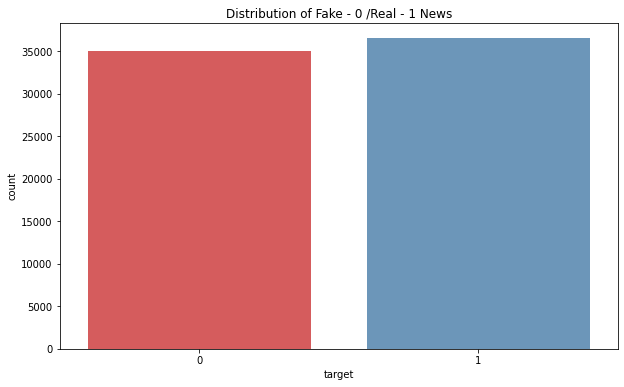

In [68]:
plt.figure(figsize = (10,6))
sns.countplot(x = df_2['target'], palette = 'Set1', alpha = 0.8)
plt.title('Distribution of Fake - 0 /Real - 1 News')

In [74]:
cols = ['title','text','target']
df = pd.concat([df_1[cols], df_2[cols]],axis = 0)

In [75]:
print(df.shape)
df.head()

(116435, 3)


,title,text,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


# Data Cleaning

In [76]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return result

In [77]:
# Transforming the unmatching subjects to the same notation
df_1.subject=df_1.subject.replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})

# Exploratory Data Analysis

# What is the distribution of Subjects between the True and Fake News? 

In [78]:
sub_tf_df=df.groupby('target').apply(lambda x:x['title'].count()).reset_index(name='Counts')
sub_tf_df.target.replace({0:'False',1:'True'},inplace=True)
display(sub_tf_df)
fig = px.bar(sub_tf_df, x="target", y="Counts",
             color='Counts', barmode='group',
             height=400,width = 500)
fig.show()

,target,Counts
0,False,58509
1,True,57926


In [79]:
sub_check=df_1.groupby('subject').apply(lambda x:x['title'].count()).reset_index(name='Counts')
display(sub_check)
fig=px.bar(sub_check,x='subject',y='Counts',color='Counts',title='Count of News Articles by Subject')
fig.update_layout(width=800, height=600)

fig.show()

,subject,Counts
0,Government News,1570
1,Middle-east,778
2,News,9050
3,PoliticsNews,18113
4,US_News,783
5,left-news,4459
6,worldnews,10145


**Observations** Political News and World News hold the most domination counts in the data set that we have considered.

# Can the News Headline be enough to predict if the news if fake or not? Lets us see in the following analysis

In [80]:
df['clean_title'] = df['title'].apply(preprocess)
df['clean_title'][0]

0    [budget, fight, looms, republicans, flip, fisc...
0    [law, enforcement, high, alert, following, thr...
Name: clean_title, dtype: object

In [81]:
df['clean_joined_title']=df['clean_title'].apply(lambda x:" ".join(x))

In [84]:
df.head()

,title,text,target,clean_title,clean_joined_title
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1,"[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal script
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1,"[senior, republican, senator, let, mueller, job]",senior republican senator let mueller job
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1,"[fbi, russia, probe, helped, australian, diplo...",fbi russia probe helped australian diplomat ti...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...


# Lets Take a look at the Word Clouds for the Titles

# Word Cloud using the Real News Headlines

In [82]:
# plt.figure(figsize = (20,20)) 
# wc_r = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_title))
# plt.imshow(wc_r, interpolation = 'bilinear')

In [83]:
# print("Top words in Real News Headline: ",list(wc_r.words_.keys())[:10])

# Word Cloud using the Fake News Headlines


In [15]:
# plt.figure(figsize = (20,20)) 
# wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 0].clean_joined_title))
# plt.imshow(wc, interpolation = 'bilinear')

In [16]:
# print("Top words in Fake News Headline: ",list(wc.words_.keys())[:10])

# Lets Look at the Count of Words Distribution in the Title

In [85]:
maxlen = -1
for doc in df.clean_joined_title:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a title of news is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_title], nbins = 50, height= 500,width = 600)

fig.show()

The maximum number of words in a title of news is = 43


In [86]:
maxlen = -1
for doc in df[df.target == 0].clean_joined_title:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a title of fake news is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df[df.target == 0].clean_joined_title], nbins = 50, height= 500,width = 600)

fig.show()

The maximum number of words in a title of fake news is = 34


# Which Subjects have received the most News Coverage?

In [87]:
maxlen = -1
for doc in df[df.target == 1].clean_joined_title:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a title of real news is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df[df.target == 1].clean_joined_title], nbins = 50, height= 500,width = 600)

fig.show()

The maximum number of words in a title of real news is = 43


Average length of Original Text:  59.286296309084
Average length of Fake Text:  60.56480199627408


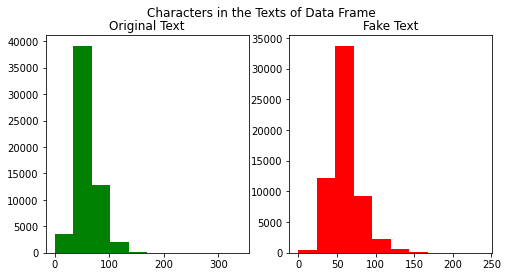

In [88]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))

text_len = df[df["target"] == 1]["clean_joined_title"].str.len()
ax1.hist(text_len, color='green')
ax1.set_title('Original Text')
print("Average length of Original Text: ",text_len.mean())

text_len = df[df["target"] == 0]["clean_joined_title"].str.len()
ax2.hist(text_len, color="red")
ax2.set_title("Fake Text")
print("Average length of Fake Text: ",text_len.mean())

fig.suptitle("Characters in the Texts of Data Frame")
plt.show();

In [89]:
def get_ngrams(corpus, n, g):
    vector = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vector.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

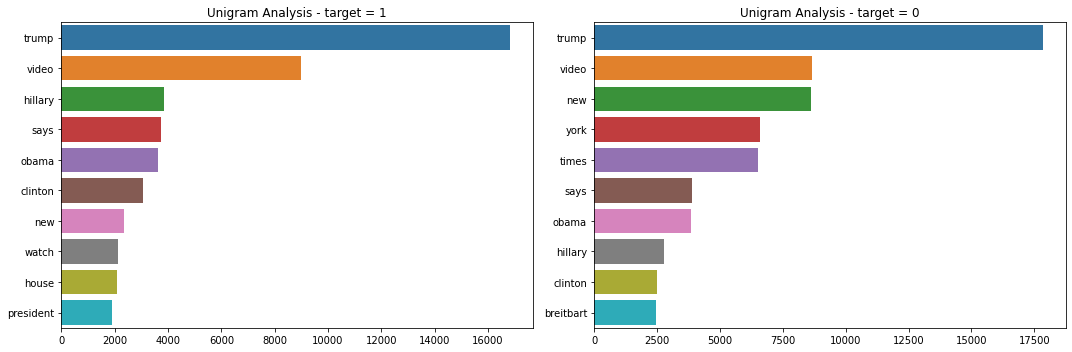

In [90]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
most_common_unigram_1 = dict(get_ngrams(df[df['target'] == 1]["clean_joined_title"], 10, 1))
sns.barplot(x=list(most_common_unigram_1.values()), y=list(most_common_unigram_1.keys()))
plt.title("Unigram Analysis - target = 1")

plt.subplot(1, 2, 2)
most_common_unigram_0 = dict(get_ngrams(df[df['target'] == 0]["clean_joined_title"], 10, 1))
sns.barplot(x=list(most_common_unigram_0.values()), y=list(most_common_unigram_0.keys()))
plt.title("Unigram Analysis - target = 0")

plt.tight_layout()
plt.show()

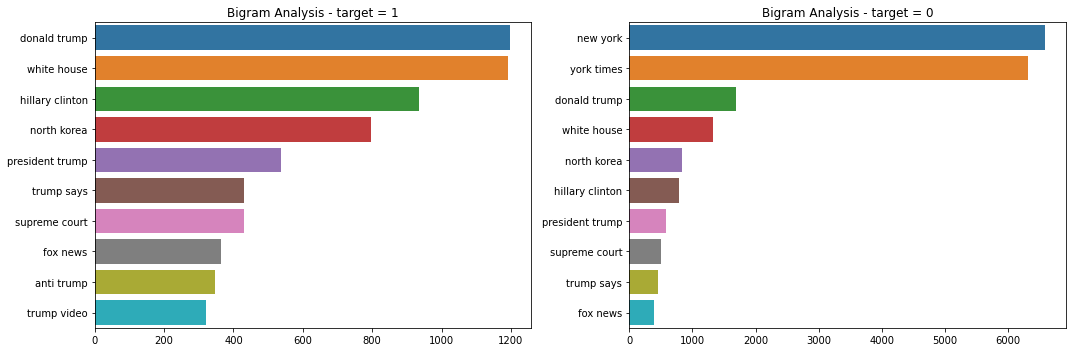

In [91]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
most_common_bigram_1 = dict(get_ngrams(df[df['target'] == 1]["clean_joined_title"], 10, 2))
sns.barplot(x=list(most_common_bigram_1.values()), y=list(most_common_bigram_1.keys()))
plt.title("Bigram Analysis - target = 1")

plt.subplot(1, 2, 2)
most_common_bigram_0 = dict(get_ngrams(df[df['target'] == 0]["clean_joined_title"], 10, 2))
sns.barplot(x=list(most_common_bigram_0.values()), y=list(most_common_bigram_0.keys()))
plt.title("Bigram Analysis - target = 0")

plt.tight_layout()
plt.show()

Most common tri grams in real news:  {'black lives matter': 187, 'onion america finest': 109, 'america finest news': 109, 'finest news source': 109, 'white house says': 91, 'new york times': 86, 'trump travel ban': 78, 'house speaker ryan': 76, 'iran nuclear deal': 76, 'factbox trump twitter': 72}
Most common tri grams in fake news:  {'new york times': 6321, 'briefing new york': 203, 'black lives matter': 175, 'evening briefing new': 131, 'trump new york': 105, 'dies new york': 102, 'white house says': 95, 'iran nuclear deal': 90, 'trump travel ban': 87, 'says new york': 85}


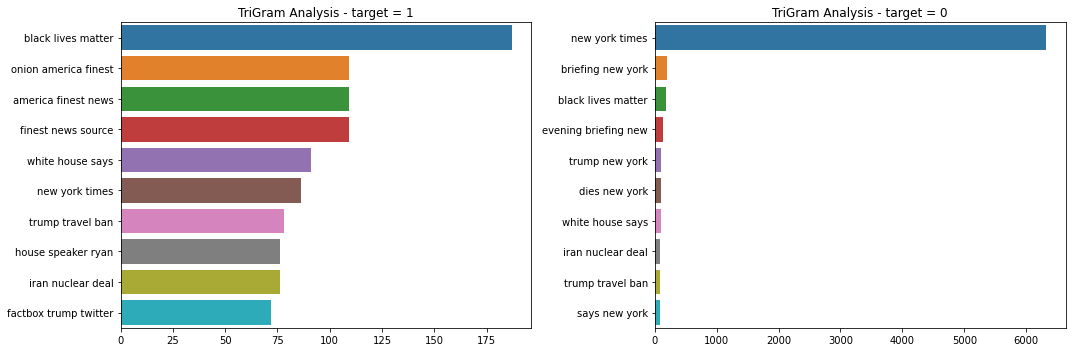

In [92]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
most_common_trigram_1 = dict(get_ngrams(df[df['target'] == 1]["clean_joined_title"], 10, 3))
sns.barplot(x=list(most_common_trigram_1.values()), y=list(most_common_trigram_1.keys()))
plt.title("TriGram Analysis - target = 1")
print("Most common tri grams in real news: ", most_common_trigram_1)
plt.subplot(1, 2, 2)
most_common_trigram_0 = dict(get_ngrams(df[df['target'] == 0]["clean_joined_title"], 10, 3))
sns.barplot(x=list(most_common_trigram_0.values()), y=list(most_common_trigram_0.keys()))
plt.title("TriGram Analysis - target = 0")
print("Most common tri grams in fake news: ", most_common_trigram_0)

plt.tight_layout()
plt.show()

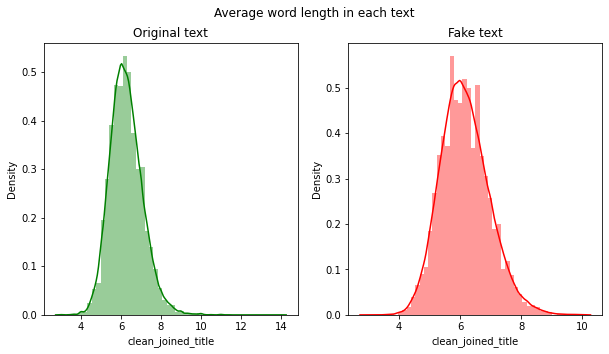

In [93]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

word = df[df['target'] == 1]['clean_joined_title'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax = ax1, color='green')
ax1.set_title('Original text')

word = df[df['target'] == 0]['clean_joined_title'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax = ax2, color='red')
ax2.set_title('Fake text')

fig.suptitle('Average word length in each text')
plt.show();

In [95]:
# Convert the 'date' column to datetime format
df_1['date'] = pd.to_datetime(df_1['date'], format="%B %d, %Y",errors='coerce')


In [94]:
df_1['date'].value_counts()

December 20, 2017                                                                                                           182
December 6, 2017                                                                                                            166
November 30, 2017                                                                                                           162
November 9, 2017                                                                                                            158
October 13, 2017                                                                                                            155
                                                                                                                           ... 
MSNBC HOST Rudely Assumes Steel Worker Would Never Let His Son Follow in His Footsteps…He Couldn’t Be More Wrong [Video]      1
September 3, 2016                                                                                       

In [96]:

# Extract the month, day, and year
df_1['month'] = df_1['date'].dt.month
df_1['day'] = df_1['date'].dt.day
df_1['year'] = df_1['date'].dt.year

# Group by month, day, and year and count the occurrences of fake news
fake_news_counts_month = df_1[df_1['target'] == 0]['month'].value_counts()
fake_news_counts_day = df_1[df_1['target'] == 0]['day'].value_counts()
fake_news_counts_year = df_1[df_1['target'] == 0]['year'].value_counts()

# Print the insights
print("Fake News Published by Month:")
print(fake_news_counts_month)
print("\nFake News Published by Day:")
print(fake_news_counts_day)
print("\nFake News Published by Year:")
print(fake_news_counts_year)

Fake News Published by Month:
5.0     2177
1.0     1275
3.0     1220
2.0     1154
4.0      972
6.0      876
7.0      777
8.0      751
10.0     718
9.0      713
11.0     655
12.0     580
Name: month, dtype: int64

Fake News Published by Day:
6.0     439
10.0    436
5.0     431
9.0     429
7.0     419
12.0    416
1.0     412
11.0    412
8.0     410
3.0     408
13.0    406
17.0    405
15.0    395
16.0    390
22.0    389
2.0     386
4.0     384
21.0    381
14.0    379
19.0    376
18.0    374
20.0    372
26.0    367
23.0    365
27.0    362
28.0    356
29.0    354
25.0    346
24.0    332
30.0    309
31.0    228
Name: day, dtype: int64

Fake News Published by Year:
2016.0    7077
2017.0    4453
2015.0     338
Name: year, dtype: int64


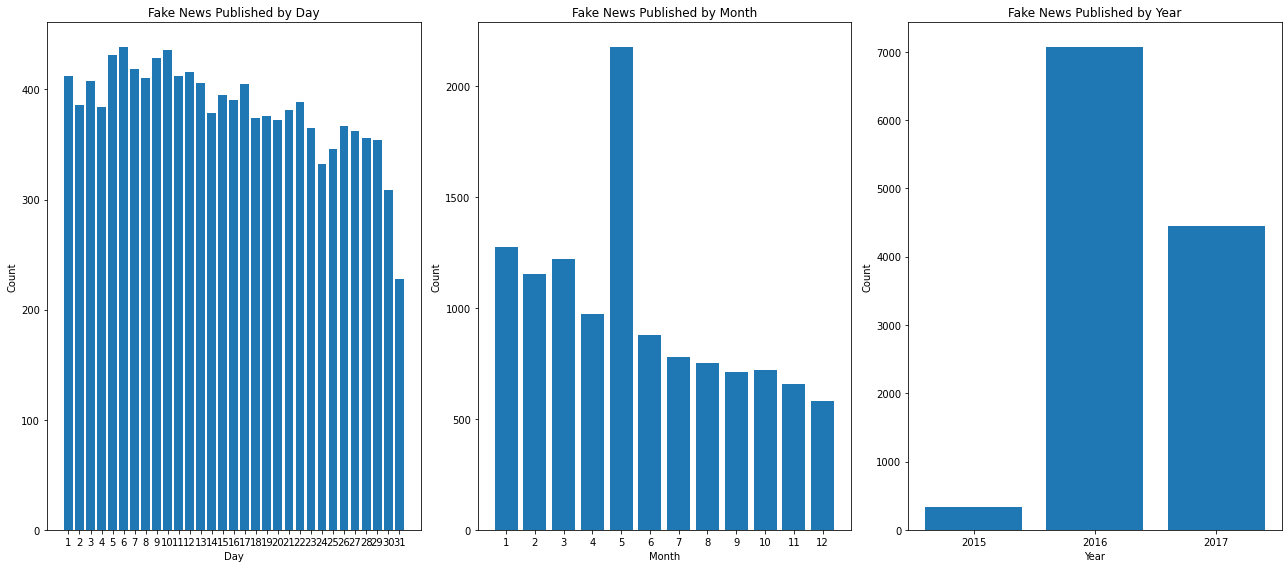

In [97]:
# Plotting value counts of month and year
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Plotting month
axes[0].bar(fake_news_counts_day.index, fake_news_counts_day.values)
axes[0].set_xticks(fake_news_counts_day.index)
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Count')
axes[0].set_title('Fake News Published by Day')

# Plotting month
axes[1].bar(fake_news_counts_month.index, fake_news_counts_month.values)
axes[1].set_xticks(fake_news_counts_month.index)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Count')
axes[1].set_title('Fake News Published by Month')

# Plotting year
axes[2].bar(fake_news_counts_year.index, fake_news_counts_year.values)
axes[2].set_xticks(fake_news_counts_year.index)
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Count')
axes[2].set_title('Fake News Published by Year')

plt.tight_layout()
plt.show()

In [98]:
df.head()

,title,text,target,clean_title,clean_joined_title
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1,"[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal script
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1,"[senior, republican, senator, let, mueller, job]",senior republican senator let mueller job
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1,"[fbi, russia, probe, helped, australian, diplo...",fbi russia probe helped australian diplomat ti...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...


In [99]:
from gensim.models import Word2Vec

corpus = [text.split() for text in df['clean_joined_title']]
emb_size = 100
# Train Word2Vec model
model_w2v = Word2Vec(sentences=corpus, vector_size=emb_size, window=5, min_count=1, workers=4, sg=0)

In [114]:
df['clean_joined_title'] = df['clean_joined_title'].astype(str)
df = df.dropna(subset=['clean_joined_title']).reset_index(drop=True)
df.shape

(116435, 5)

In [106]:
meta_text_vec = []
for text in df['clean_joined_title']:
    vec = np.zeros(emb_size)
    tokens = text.split()
    for token in tokens:
        if token in model_w2v.wv:
            vec += model_w2v.wv[token]
    meta_text_vec.append(vec)
meta_text_vec = np.array(meta_text_vec)
meta_text_vec.shape

(116435, 100)

In [108]:
words = model_w2v.wv.index_to_key
# words,len(words)

In [112]:
df_embed.shape

(116435, 100)

In [113]:
df[['target']].shape

(116435, 1)

In [115]:
df_embed = pd.DataFrame(meta_text_vec,columns = ['embed_{}'.format(i) for i in range(meta_text_vec.shape[1])])
final_df = pd.concat([df_embed, df[['target']]],axis = 1)
final_df.head()

,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_91,embed_92,embed_93,embed_94,embed_95,embed_96,embed_97,embed_98,embed_99,target
0,-3.570240,-2.803373,-2.554232,-0.106434,0.250771,-1.301584,-2.329370,-0.392372,4.628004,-3.979166,...,3.328781,4.353628,3.194135,1.394847,0.248404,-0.223095,1.888524,0.157861,2.502262,1
1,-2.908017,2.455392,-2.110239,1.305294,0.582295,-2.320805,-2.858762,0.900695,4.572054,-0.224374,...,1.264421,2.602593,-0.417223,1.416479,3.616037,0.233119,1.427202,-3.339051,3.654810,1
2,-1.448401,-3.275209,-1.026117,-2.486848,1.204069,-4.548593,-0.637636,-2.377687,6.101851,-3.428769,...,3.263841,3.248214,3.120166,1.702474,-1.572957,1.035061,4.367816,0.679509,3.884487,1
3,-3.408945,0.669949,-3.984049,2.098730,1.751097,-4.748281,-3.382129,-3.584832,4.995571,1.408581,...,3.665572,1.953220,-2.979264,4.541581,0.762408,5.407749,4.735015,-5.043454,6.737858,1
4,-2.590725,-0.240896,-0.613958,0.896606,-0.125526,-2.523806,0.075854,-0.068514,2.739620,-2.833008,...,0.795078,1.774929,-0.490356,1.994058,1.871106,0.019543,-0.384379,0.198380,3.747008,1


In [118]:
final_df.target.value_counts()

0    58509
1    57926
Name: target, dtype: int64

In [116]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
from random import randint
import warnings
warnings.filterwarnings("ignore")
classifiers = {'Logistic': LogisticRegression(max_iter=1000),
               'KNN': KNeighborsClassifier(),
               'RandomForest':RandomForestClassifier(),
               'XGBOOST': xgb.XGBClassifier(n_estimators=300, random_state=0)}


In [117]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def split(df,label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te
data_bc = final_df.drop(columns='target')
label_bc = final_df['target']
X_train, X_test, y_train, y_test = split(data_bc, label_bc)

for key in classifiers:
    classifiers[key].fit(X_train, y_train)
    y_pred = classifiers[key].predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model: {key}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 score: {f1}")
    print()


Model: Logistic
Accuracy: 0.5706138994812601
Precision: 0.55480672830567
Recall: 0.688532522292113
F1 score: 0.6144782702569321

Model: KNN
Accuracy: 0.39705932872994604
Precision: 0.39859266079179273
Recall: 0.4189534803345545
F1 score: 0.40851952953863785

Model: RandomForest
Accuracy: 0.30842694699233913
Precision: 0.3132418886837246
Recall: 0.32833344853805213
F1 score: 0.3206101717795552

[00:47:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

In [ ]:
import shap

# Create a SHAP explainer object for the logistic regression model
lr_explainer = shap.LinearExplainer(classifiers['Logistic'], X_train)


In [ ]:
# Compute SHAP values for a sample of the test data
lr_shap_values = lr_explainer.shap_values(X_test)

In [ ]:
# Visualize the SHAP values for the logistic regression model
shap.summary_plot(lr_shap_values, X_test,max_display =10)

In [ ]:
xgb_explainer = shap.Explainer(classifiers['XGBOOST'])
xgb_shap_values = xgb_explainer(X_test)


In [ ]:
shap.summary_plot(xgb_shap_values, X_test,max_display =10)


In [ ]:
# Create SHAP positive/negative impact plot
shap.plots.bar(xgb_explainer(X_test))

In [ ]:
shap.summary_plot(xgb_shap_values, X_test, plot_type="bar",max_display =10)


### CNN-LSTM training

In [119]:
# feature extraction using Word2Vec
sentences = [nltk.word_tokenize(text) for text in df['clean_joined_title']]
word2vec_model = Word2Vec(sentences, vector_size=100, min_count=1)
# create embeddings
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 100

In [120]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, Dropout
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
tf.compat.v1.enable_eager_execution()


In [121]:
vocabulary_size = len(word2vec_model.wv.key_to_index)

tokenizer = Tokenizer(num_words= vocabulary_size, lower=True, char_level=False)
tokenizer.fit_on_texts(df['clean_joined_title'].values)
sequences = tokenizer.texts_to_sequences(df['clean_joined_title'].values)
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

embedding_matrix = np.zeros((vocabulary_size + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec_model.wv.key_to_index:
        embedding_matrix[i] = word2vec_model.wv[word]


In [122]:
# model training
X_train, X_test, y_train, y_test = train_test_split(data, df['target'], test_size=0.2, random_state=42)


In [123]:
input_tensor = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = tf.keras.layers.Embedding(vocabulary_size+1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)(input_tensor)
dropout_layer = tf.keras.layers.Dropout(0.2)(embedding_layer)
conv1d_layer = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(dropout_layer)
maxpooling1d_layer = tf.keras.layers.MaxPooling1D(pool_size=2)(conv1d_layer)
lstm_layer = tf.keras.layers.LSTM(100)(maxpooling1d_layer)
output_tensor = tf.keras.layers.Dense(1, activation='sigmoid')(lstm_layer)

cnn_lstm_model = tf.keras.models.Model(inputs=input_tensor, outputs=output_tensor)
cnn_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [124]:
# from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3)
history = cnn_lstm_model.fit(X_train, np.array(y_train), epochs=10, batch_size=256,
#                                callbacks = [early_stopping],
                             validation_split = 0.2)


Train on 74518 samples, validate on 18630 samples
Epoch 1/10
74518/74518 [==============================] - 128s 2ms/sample - loss: 0.6468 - acc: 0.5678 - val_loss: 0.6351 - val_acc: 0.5721
Epoch 2/10
74518/74518 [==============================] - 108s 1ms/sample - loss: 0.6326 - acc: 0.5712 - val_loss: 0.6324 - val_acc: 0.5761
Epoch 3/10
74518/74518 [==============================] - 94s 1ms/sample - loss: 0.6298 - acc: 0.5740 - val_loss: 0.6301 - val_acc: 0.5704
Epoch 4/10
59392/74518 [======================>.......] - ETA: 16s - loss: 0.6285 - acc: 0.5787

KeyboardInterrupt: 

In [ ]:
cnn_lstm_model.save('lstm_model.pb')

In [ ]:
# Plotting train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
# Plotting train and validation loss
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:

y_pred_prob = cnn_lstm_model.predict(X_test)

# Get the class labels as integers
# y_pred = np.argmax(y_pred_prob, axis=1)
y_pred = [1 if each > 0.5 else 0 for each in y_pred_prob ]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
